# Motor Identification

In [1]:
import sys
sys.path.append('..')

In [2]:
%matplotlib inline  
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math
import time

In [4]:
from ctrl.block.linear import Gain, Feedback, Sum
from ctrl.block.logger import Logger

In [5]:
from ctrl.client import Controller
HOST, PORT = "192.168.10.102", 9999
HOST, PORT = "localhost", 9999
controller = Controller(host = HOST, port = PORT)

##Static Reponse

In [6]:
controller.reset()
controller.add_sink('logger', 
                    Logger(), 
                    ['clock', 'encoder1','motor1'])

ConnectionRefusedError: [Errno 61] Connection refused

In [312]:
print(controller.info('all'))

> Controller with 5 signal(s), 4 source(s), 2 sink(s), and 0 filter(s)
> period = 0.01s
> signals
  1. theta
  2. encoder1
  3. pot1
  4. motor1
  5. clock
> sources
  1. clock[enabled] >> clock
  2. encoder1[enabled] >> encoder1
  3. pot1[enabled] >> pot1
  4. inclinometer1[enabled] >> theta
> filters
> sinks
  1. motor1 >> motor1[enabled]
  2. clock, encoder1, motor1 >> logger[enabled]



In [313]:
print('> Identifying motor static response')
controller.set_sink('logger',reset=True)
dT = 3
dD = 5
ts = []
with controller:
    time.sleep(1)
    for duty_cycle in range(0,100+dD,dD):
        print('\r  duty cycle = {}%'.format(100-duty_cycle), end='')
        ts.append(controller.get_signal('clock'))
        controller.set_signal('motor1', 100-duty_cycle)
        time.sleep(dT)
print('\n< Done')
print('> Retrieving data')
log = controller.read_sink('logger')
print('< Done')

> Identifying motor static response
  duty cycle = 0%
< Done
> Retrieving data
< Done


In [314]:
# Duration of transient
Tt = 1

In [315]:
t = log[:,0]
pos = 2*math.pi*log[:,1]
ref = log[:,2]

vel = np.zeros(t.shape, float)
vel[1:] = (pos[1:]-pos[:-1])/(t[1:]-t[:-1])

ssvel = np.array([])
sst = np.array([])
ssref = np.array([])
for (tk,tr) in zip(ts[:-1],ts[1:]):
    ind = np.where((t > tk + Tt)&(t < tr))
    sst = np.append(t[ind], sst)
    ssvel = np.append(vel[ind], ssvel)
    ssref = np.append(ref[ind], ssref)

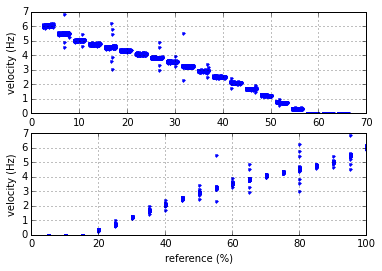

In [316]:
plt.subplot(2,1,1)
plt.plot(sst, ssvel, '.')
plt.xlabel('t (s)')
plt.ylabel('velocity (Hz)')
plt.grid()

plt.subplot(2,1,2)
plt.plot(ssref, ssvel, '.')
plt.xlabel('reference (%)')
plt.ylabel('velocity (Hz)')
plt.grid()

In [317]:
def func(x, a, v0):
    return a * (x - v0)

import scipy.optimize as optimize

ind = np.where(ssvel > 0)
pars, residues = optimize.curve_fit(func, ssref[ind], ssvel[ind])
a, v0 = pars.tolist()
print('a = {:4.3f}, v0 = {:4.3f}'.format(a,v0))

a = 0.066, v0 = 9.839


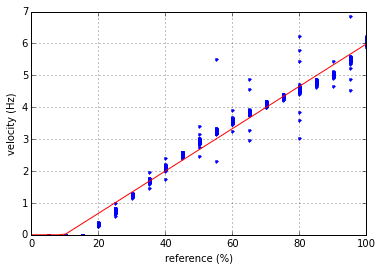

In [318]:
plt.plot(ssref, ssvel, '.', np.linspace(0,100), np.maximum(a * (np.linspace(0,100) - v0),0),'r-')
plt.xlabel('reference (%)')
plt.ylabel('velocity (Hz)')
plt.grid()

##Dynamic Response

With a constant input:
$$
\omega(t) = \bar{\omega} \left ( 1 - e^{\lambda t} \right )
$$
where:
$$
\begin{aligned}
\bar{\omega} &= a \, (v_a - v_0), & a &= \frac{k_m}{b_m}, & \lambda &= \frac{b_m}{J_m}
\end{aligned}
$$

In [327]:
print('> Identifying motor dynamic response')
K = 10
T0 = 1
T1 = 2
tref = []
duty = 90
with controller:
    controller.set_source('clock',reset=True)
    controller.set_sink('logger',reset=True)
    for k in range(K):
        print('\r  Experiment #{}'.format(k+1),end='')
        time.sleep(T0)
        controller.set_signal('motor1',duty)
        t0=controller.get_signal('clock')
        time.sleep(T1)
        controller.set_signal('motor1',0)
        t1=controller.get_signal('clock')
        time.sleep(T0)
        tref.append((t0,t1))
print('\n< Done')
print('> Retrieving data')
log = controller.read_sink('logger')
print('< Done')

> Identifying motor dynamic response
  Experiment #10
< Done
> Retrieving data
< Done


In [328]:
t = log[:,0]
pos = 2*math.pi*log[:,1]
ref = log[:,2]

vel = np.zeros(t.shape, float)
vel[1:] = (pos[1:]-pos[:-1])/(t[1:]-t[:-1])

vref = np.zeros(t.shape, float)
vref[1:] = (ref[1:]-ref[:-1])/(t[1:]-t[:-1])
tref = np.vstack((t[vref>0],t[vref<0])).transpose().tolist()

In [329]:
Ts = controller.get_period()
print('Ts = {}'.format(Ts))

Ts = 0.01


In [330]:
N = 0
omegabar = 0
for (tk,tr) in tref:
    indss = np.where((t > tk+Tt) & (t < tr))
    nss = len(indss[0])
    omegabar += nss * np.mean(vel[indss])
    N += nss
omegabar /= N
print('N = {}, omegabar = {:5.3f}[{:5.3f}]'.format(N, omegabar, a * (duty-v0)))

N = 1160, omegabar = 5.003[5.321]


In [331]:
N = 0
vtr = np.array([])
ttr = np.array([])
vtrx = np.array([])
ttrx = np.array([])
for (tk,tr) in tref:
    indtr = np.where((t > tk + Ts) & (t < tk + 0.15*Tt))
    vtr = np.hstack((vtr,vel[indtr]))
    ttr = np.hstack((ttr,t[indtr]-tk-Ts))
    indtrx = np.where((t > tk + Ts) & (t < tk + Tt))
    vtrx = np.hstack((vtrx,vel[indtrx]))
    ttrx = np.hstack((ttrx,t[indtrx]-tk-Ts))

In [332]:
def func(x, a, b):
    return np.maximum(-a * x, b)

import scipy.optimize as optimize

x = ttr
y = np.log(1-vtr/omegabar)
ind = ~np.isnan(y)
x = x[ind]
y = y[ind]

pars, residues = optimize.curve_fit(func, x, y, sigma=1-x**(8),absolute_sigma=False)
lamb, eta = pars
print('lambda = {:4.3f}, eta = {:4.3f}'.format(lamb,eta))

lambda = 21.828, eta = -2.513


/Users/mauricio/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:7: RuntimeWarning: invalid value encountered in log


(0, 0.4)

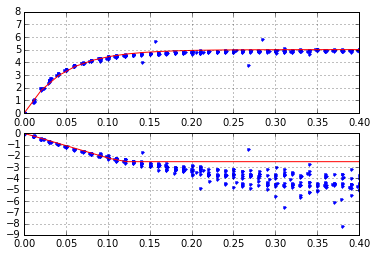

In [333]:
plt.subplot(2,1,1)
plt.plot(ttrx,vtrx,'.',np.linspace(0,Tt),omegabar*(1-np.exp(-lamb*np.linspace(0,Tt))),'r-')
plt.grid()
plt.xlim(0,0.4)

plt.subplot(2,1,2)
plt.plot(ttrx,np.log(1-vtrx/omegabar),'.',
         np.linspace(0,Tt),np.maximum(-lamb*np.linspace(0,Tt),eta),'r-')
plt.grid()
plt.xlim(0,0.4)

#Final model parameters

With a constant input:
$$
\omega(t) = \bar{\omega} \left ( 1 - e^{\lambda t} \right )
$$
where:
$$
\begin{aligned}
\bar{\omega} &= a \, (v_a - v_0), & a &= \frac{k_m}{b_m}, & \lambda &= \frac{b_m}{J_m}
\end{aligned}
$$

In [334]:
print('a = {:5.3f}\nv0 = {:5.3f}\nduty = {:5.3f}\nomegabar = {:5.3f}\nlambda = {:5.3f}'.format(a,v0,duty,omegabar,lamb))

a = 0.066
v0 = 9.839
duty = 90.000
omegabar = 5.003
lambda = 21.828
